In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import scipy.stats as ss
import matplotlib.pyplot as plt
import plotly.express as px
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

**Приложение знакомств**  

В приложении для онлайн-знакомств пользователи видят анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.  

Разработан новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.  

Необходимо оценить, правда ли, что новый алгоритм улучшил качество сервиса. **Вопрос: стоит ли включать новую систему поиска анкет на всех пользователей.**  

In [2]:
path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-gazizova/MathStat/dating_data.csv'
df_dating = pd.read_csv(path)  
df_dating.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [3]:
df_dating.shape

(14514, 4)

In [4]:
df_dating.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

Сравнивать будем категориальные данные, метрика is_match, являются категориальным типом данных, так как есть две категории (случился мэтч, либо не случился). Соответственно, будем применять хи-квадрат тест для сравнения двух групп.

In [5]:
df_dating.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [6]:
# Посмотрим, сколько мэтчей случилось в каждой из групп

df = df_dating.groupby(['group', 'is_match']).agg({'is_match':'count'})
df

is_match
group is_match          
0     0             3858
      1              934
1     0             5813
      1             3909

Посмотрим, сколько в каждой группе было экспериментов - количество событий

In [7]:
df_dating.query("group == 1").is_match.count()


9722

In [8]:
df_dating.query("group == 0").is_match.count()


4792

In [9]:
df_dating.group.value_counts(normalize=True).mul(100)

1    66.983602
0    33.016398
Name: group, dtype: float64

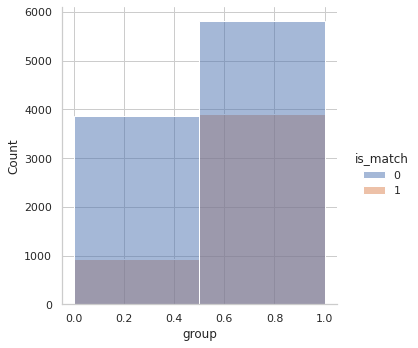

In [10]:
# построим диаграмму и посмотрим визуально
    
sns.displot(data=df_dating[['is_match', 'group']].dropna(), 
            x='group', hue='is_match', bins=2)

Видим, что в группе 1 (которые использовали новый алгоритм) практически в два раза больше количество событий (лайк, либо дизлайк), чем в группе 0.  

Теперь проверяем количество мэтчей по каждой из групп в процентном соотношении.

In [11]:
df1 = df_dating.query("group == 1")
df1.is_match.value_counts(normalize=True).mul(100)

0    59.792224
1    40.207776
Name: is_match, dtype: float64

In [12]:
df0 = df_dating.query("group == 0")
df0.is_match.value_counts(normalize=True).mul(100)

0    80.509182
1    19.490818
Name: is_match, dtype: float64

Визуально можно видеть различия, но проверим это с помощью статистрического теста.

Проверка гипотезы с помощью статистического теста.  
Поскольку переменная _is_match_ принимает всего два значения (тоже самое верно и для переменной _group_ ), значит она является категориальной. Поскольку есть две категориальные переменные, то воспользуемся критерием **_хи-квадрат_**.  

**Мы имеем две гипотезы:**  
- **𝐻0:** взаимосвязи между is_match и переменной group нет  
- **𝐻1:** переменная is_match зависит от тестировочной группы, к которой относится рассматриваемая пара.

In [15]:
# создаем таблицу сопряженности

df_crostab = pd.crosstab(df_dating.is_match, df_dating.group)
df_crostab

group,0,1
is_match,,
0,3858,5813
1,934,3909


In [16]:
# получаем показателистатистики и p-value
    
from scipy.stats import chi2_contingency, chi2 

stat, p, dof, expected = chi2_contingency(df_crostab)
stat, p, dof, expected

(618.6889141576197,
 1.441829916366341e-136,
 1,
 array([[3193.01584677, 6477.98415323],
        [1598.98415323, 3244.01584677]]))

In [17]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Применив статистический тест хи-квадрат мы **отклоняем нулевую гипотезу** и принимаем первую, заключаем, что **_существует зависимость двух категориальных переменных group и is_match_**.  
**Вывод:**  Качество сервиса улучшилось, и соответственно, применяем новый алгоритм поиска на всех пользователей.

In [16]:
# проверяем с помощью регрессионного анлиза

import statsmodels.api as sm
import statsmodels.formula.api as smf


results = smf.ols('is_match ~ group', df_dating).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               is_match   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     647.2
Date:                Wed, 13 Mar 2024   Prob (F-statistic):          1.04e-139
Time:                        13:39:15   Log-Likelihood:                -9366.5
No. Observations:               14514   AIC:                         1.874e+04
Df Residuals:                   14512   BIC:                         1.875e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1949      0.007     29.243      0.0